# Udacity Self-Driving Car Nanodegree Program
## Project 3 - Behavioral Cloning

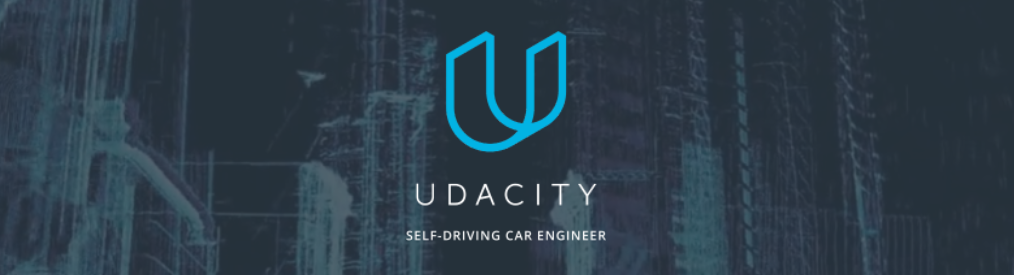

In [1]:
from IPython.display import Image
Image(filename='images/loading_screen.png')

This project builds and implements a **behavioral cloning (end-to-end) network** that drives a simulated autonomous vehicle around two different test tracks. The first track is used to generate data that the car will use to react and recover in changing road conditions. Data is recorded in **"TRAINING MODE"** for several laps before being saved to the Jupyter notebook heirarchy in the **data** folder. From there, the data is preprocessed and used to train the pipeline's deep neural network model, as explained below.

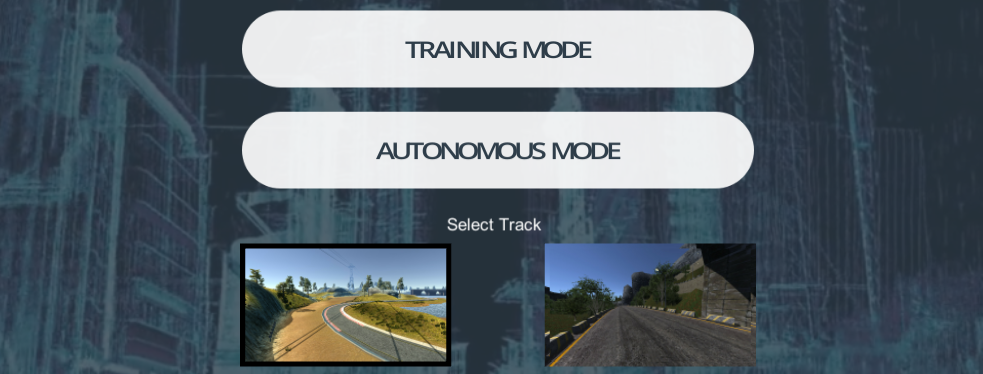

In [2]:
from IPython.display import Image
Image(filename='images/main_menu.png')

**"AUTONOMOUS MODE"** is used to test the model's performance and ensure that it is not overfitting the data after training. Driving simulation is accomplished by running the car's drive server using the following code from the Terminal after a cd into the project's directory:

#### $ python drive.py model.json

Selecting **"AUTONOMOUS MODE"** will start running the model and the car will begin driving on its own.

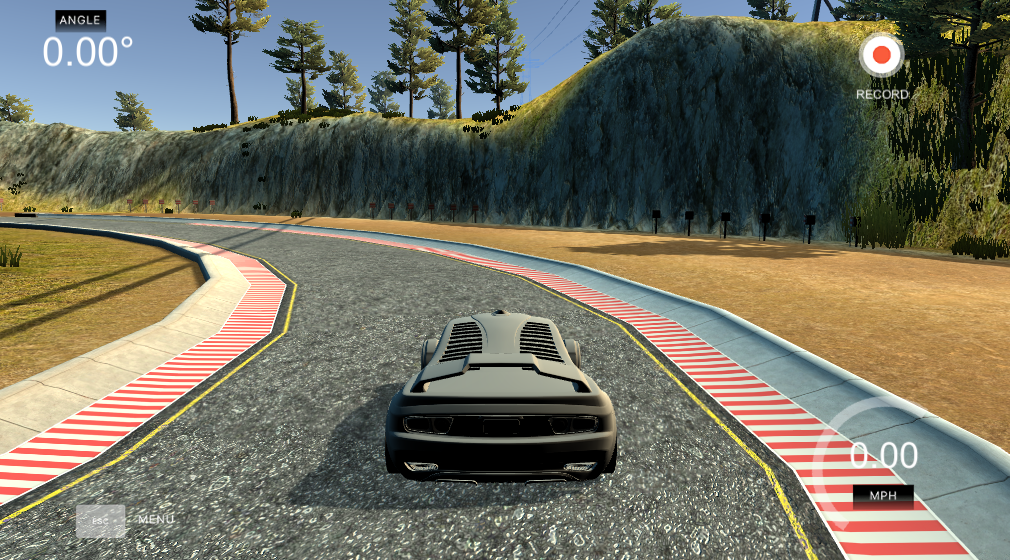

In [3]:
from IPython.display import Image
Image(filename='images/first_track.png')

Udacity has requested that the following conventions be used for this project:

+ **model.py** - The script used to create and train the model.

+ **drive.py** - The script to drive the car. You can feel free to resubmit the original drive.py or make modifications and submit your modified version.

+ **model.json** - The model architecture.

+ **model.h5** - The model weights.

+ **README.md** - explains the structure of your network and training approach. While we recommend using English for good practice, writing in any language is acceptable (reviewers will translate). There is no minimum word count so long as there are complete descriptions of the problems and the strategies. See the rubric for more details about the expectations.

**Because the model is being run in a Jupyter notebook, model.py is the model_py function in the pipeline rather than a separate file. Additionally, README.md is an overall summary that references this pipeline for further detail.**


In [4]:
#Import Statements

#For read_csv
import csv

#For process_feature and process_label
from scipy.misc import imread
import numpy as np

#For split_train_valid_test
import math
import random

In [5]:
#Pre-processing for features and labels

def process_feature(image):
    return np.array([imread("{}/{}".format("data", image))]).astype(np.float32)

def process_label(steering):
    return np.array([float(steering)])

In [6]:
def split_train_valid_test(data, training=0.75, validation=0.20, testing=0.05):
    
    #Get the total number of rows in driving_log.csv
    rows = len(data)
   
    #Calculate ranges for each of the sets using math.floor
    train = math.floor(rows * training)
    validate = train + math.floor(rows * validation)
    test = validate + math.floor(rows * testing) 

    #Slice driving_log.csv into three sets using slice()
    training_slice = slice(0, train)
    validation_slice = slice(train, validate)
    testing_slice = slice(validate, test)

    #Create three variables that reference each of the slices created in driving_log.csv
    training_set = driving_log[training_slice]
    validation_set = driving_log[validation_slice]
    testing_set = driving_log[testing_slice]

    return (training_set, validation_set, testing_set)

In [7]:
def read_csv(filename):
    with open(filename) as file:
        reader = csv.reader(file, skipinitialspace=True)
        #Exclude header row of driving_log.csv
        next(reader)
        return [(row[0], row[1], row[2], row[3]) for row in reader]

In [8]:
def generator(data):
    random.shuffle(data)
    for center, left, right, steering in data:
        yield (process_feature(center), process_label(steering))
        yield (process_feature(left), process_label(float(steering) + 0.10))
        yield (process_feature(right), process_label(float(steering) - 0.10))

def run_generator(data):
    while True:
        try:
            yield next(generator(data))
        except StopIteration:
            generator(data)

#Read driving_log.csv data
driving_log = read_csv('data/driving_log.csv')
            
#Split driving_log data into training, validation, and testing sets
training_set, validation_set, testing_set = split_train_valid_test(driving_log)            

print('Generating data...')
print('')
print('Total Data Rows: {}'.format(len(driving_log) - 1)) #Subtract header row
print("Training Rows: {}".format(len(training_set)))
print("Validation Rows: {}".format(len(validation_set)))
print("Testing Rows: {}".format(len(testing_set)))

generate_training = run_generator(training_set)
generate_validation = run_generator(validation_set)
generate_testing = run_generator(testing_set)

Generating data...

Total Data Rows: 8035
Training Rows: 6027
Validation Rows: 1607
Testing Rows: 401


### Model Architechture

In [ ]:
from keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from keras.models import Sequential

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.applications.inception_v3 import InceptionV3

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import numpy
import json

EPOCHS = 3
EXAMPLES = len(training_set) + len(validation_set) + len(testing_set)

P_TRAIN = 0.75 
P_VALID = 0.20
P_TEST = 0.05

N_TRAIN = math.floor(EXAMPLES * P_TRAIN)
N_VALID = math.floor(EXAMPLES * P_VALID)
N_TEST = math.floor(EXAMPLES * P_TEST)

def resize(data):
    return data[:, 60:134, 0:320]

def normalize(data):
    return data / 127.5 - 1

model = Sequential()
model.add(Lambda(resize, input_shape=(160, 320, 3), name="resize"))
model.add(Lambda(normalize, name="normalize"))

model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(LeakyReLU())

model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(LeakyReLU())

model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(LeakyReLU())

model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(LeakyReLU())

model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(LeakyReLU())

model.add(Dense(100))
model.add(LeakyReLU())

model.add(Dense(50))
model.add(LeakyReLU())

model.add(Dense(10))
model.add(LeakyReLU())

model.add(Dense(1))

Using TensorFlow backend.


### Training the Model (model.py)

In [ ]:
#Train model and save for later use

def save_model(model):
    with open('model.json', 'w') as f:
        json.dump(model.to_json(), f)

def save_weights():
    model.save_weights('model.h5')

model.compile(loss='mse', optimizer=Adam(lr=0.0001))       

training = model.fit_generator(generator=generate_training,
                              samples_per_epoch=N_TRAIN,
                              nb_epoch=EPOCHS,
                              verbose=1,
                              validation_data=generate_validation,
                              nb_val_samples=N_VALID)

#Save model and weights
save_model(model)
save_weights()

print("Model and weights saved to home directory.")

Epoch 1/3
4540/6026 [=====================>........] - ETA: 22s - loss: 0.0116

In [ ]:
t = training.history
print("Training Loss: {:.3%}".format(t["loss"][-1]))
print("Validation Loss: {:.3%}".format(t["val_loss"][-1]))
out = model.evaluate_generator(generate_testing, val_samples=N_TEST)
print("Testing Loss: {:.3%}".format(out))

In [ ]:
from IPython.display import Image
Image(filename='images/second_track.png')

This is the second track available in the simulator. Once the model is trained, this track used to verify performance on new terrain.

### Running the Model in the Simulator

In [ ]:
#Launch the simulator
!open -a Behavioral_Cloning_Simulator

In [ ]:
#Run the drive server to begin autonomous steering
!python drive.py model.json